# Metrics 

### Setup imports, qrels files and query URL's

In [1]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd


QRELS_FILE_1 = "qrels/qrel1_constructors_enhanced.txt"
QRELS_FILE_1_1 = "qrels/qrel1_constructors_enhanced.txt"
QRELS_FILE_2 = "qrels/qrel2_seasons.txt"

# Queries
# Constructors that have british nationality and mentions 1990 in their description
QUERY_URL_1 = "http://localhost:8983/solr/constructors/select?fq=constructor_bio%3A1990&indent=true&q.op=OR&q=nationality%3Abritish&rows=12&useParams="
QUERY_URL_1_1 = "http://localhost:8983/solr/constructors/select?defType=edismax&fq=nationality%3A%22British%22&indent=true&q.op=OR&q=constructor_bio%3A1990s&qf=constructor_bio%5E2&rows=12&useParams="

# Drivers Changes in Ferrari
QUERY_URL_2 = "http://localhost:8983/solr/seasons/select?indent=true&q.op=OR&q=driver_changes%3AFerrari&useParams="

#TODO: Make new queries and organize them in a dictionary or list or tuples
# Drivers whare born in or after 1990
# QUERY_URL_2 = ""

querys_dict = {
    'query1': [QRELS_FILE_1, QUERY_URL_1, 'constructor_bio'],
    'query1_enhanced': [QRELS_FILE_1_1, QUERY_URL_1_1, 'constructor_bio'],
    'query2': [QRELS_FILE_2, QUERY_URL_2, 'driver_changes']
}

query = 'query1'

# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(querys_dict[query][0], encoding="utf-8").readlines()))

# Get query results from Solr instance
results = requests.get(querys_dict[query][1]).json()["response"]["docs"]

# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

### Precision metric

In [2]:
@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    relevant_count = 0

    for idx, doc in enumerate(results):
        if doc[querys_dict[query][2]] in relevant:
            relevant_count += 1
            precision_at_k = relevant_count / (idx + 1)
            precision_values.append(precision_at_k)

    if not precision_values:
        return 0.0

    return sum(precision_values)/len(precision_values)

### Precision at 10 metric

In [3]:
@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc[querys_dict[query][2]] in relevant])/n

### Main function to calculate metrics

In [4]:
def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric','Value']] +
    [
        [evaluation_metrics[m], calculate_metric(m, results, relevant)]
        for m in evaluation_metrics
    ]
)

with open('results_1_enhanced.tex','w') as tf:
    tf.write(df.style.to_latex())

### Precision-Recall metric

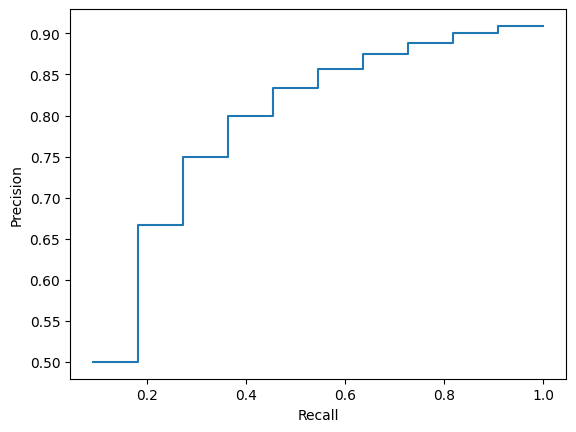

In [5]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
precision_values = [
    len([
        doc 
        for doc in results[:idx]
        if doc[querys_dict[query][2]] in relevant
    ]) / idx 
    for idx, _ in enumerate(results, start=1)
]

recall_values = [
    len([
        doc for doc in results[:idx]
        if doc[querys_dict[query][2]] in relevant
    ]) / len(relevant)
    for idx, _ in enumerate(results, start=1)
]

precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}

# Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
recall_values = sorted(set(recall_values))

# Extend matching dict to include these new intermediate steps
for idx, step in enumerate(recall_values):
    if step not in precision_recall_match:
        if recall_values[idx-1] in precision_recall_match:
            precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
        else:
            precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
disp.plot()
plt.savefig('precision_recall_' + query + '.png')
